In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os
# Create a MirroredStrateg, If Multi-GPU available
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' 
tf.config.set_soft_device_placement(True)
# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2']) 
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from livelossplot.keras import PlotLossesCallback
from livelossplot import PlotLossesKerasTF
import efficientnet.keras as efn
import h5py, glob, re, cv2, math, matplotlib
import tensorflow.keras as keras
import pandas as pd
from pandas import read_csv
import numpy as np
from scipy import stats
import itertools, random

# from cnn_utils import *
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from PIL import Image  
import pdb
from statistics import mode 
from IPython.display import clear_output

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

np.random.seed(1)
# Setting the seed for python random numbers
random.seed(1254)
# Setting the graph-level random seed.
tf.random.set_seed(89)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
!CUDA_VISIBLE_DEVICES=2

# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2'])
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# def setup_multi_node_training(): # IMPORTANT: SET UP TF_CONFIG FOR MULTINODE TRAINING HERE os.environ[“TF_FORCE_GPU_ALLOW_GROWTH”] = “true” tf.config.set_soft_device_placement(True) mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(tf.distribute.experimental.CollectiveCommunication.NCCL) # Constructs the configuration run_config = tf.estimator.RunConfig( train_distribute=mirrored_strategy, ) return run_config
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Using TensorFlow backend.


Num GPUs Available:  1


## Load Data

In [2]:
filename = 'Datasets/All_subjects_RDmap.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train1 = np.array(data["train_img"])
y_train1 = np.array(data["train_labels"])
x_test1 = np.array(data["test_img"])
y_test1 = np.array(data["test_labels"])
data.close()
print(x_train1.shape)
print(y_train1.shape)
print(x_test1.shape)
print(y_test1.shape)

Selected File: Datasets/All_subjects_RDmap.hdf5
(527, 605, 128, 128, 3)
(527, 605, 19)
(132, 605, 128, 128, 3)
(132, 605, 19)


In [3]:
filename = 'Datasets/All_subjects_RAmap.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train2 = np.array(data["train_img"])
y_train2 = np.array(data["train_labels"])
x_test2 = np.array(data["test_img"])
y_test2 = np.array(data["test_labels"])
data.close()
print(x_train2.shape)
print(y_train2.shape)
print(x_test2.shape)
print(y_test2.shape)

Selected File: Datasets/All_subjects_RAmap.hdf5
(527, 605, 128, 128, 3)
(527, 605, 19)
(132, 605, 128, 128, 3)
(132, 605, 19)


In [4]:
# windowed RD
interval = range(0,600)
x_train11 = np.reshape(x_train1[:,interval,:,:,:], (x_train1.shape[0],120,5,x_train1.shape[2],x_train1.shape[3],x_train1.shape[4]))
x_test11 = np.reshape(x_test1[:,interval,:,:,:], (x_test1.shape[0],120,5,x_test1.shape[2],x_test1.shape[3],x_test1.shape[4]))
y_train11 = np.reshape(np.argmax(y_train1[:,interval,:],-1), (y_train1.shape[0],120,5))
y_test11 = np.reshape(np.argmax(y_test1[:,interval,:],-1), (y_test1.shape[0],120,5))
y_train11 = to_categorical(np.squeeze(stats.mode(y_train11,2)[0]))
y_test11 = to_categorical(np.squeeze(stats.mode(y_test11,2)[0]))
print(x_train11.shape)
print(y_train11.shape)
print(x_test11.shape)
print(y_test11.shape)  

# windowed RA
x_train12 = np.reshape(x_train2[:,interval,:,:,:], (x_train2.shape[0],120,5,x_train2.shape[2],x_train2.shape[3],x_train2.shape[4]))
x_test12 = np.reshape(x_test2[:,interval,:,:,:], (x_test2.shape[0],120,5,x_test2.shape[2],x_test2.shape[3],x_test2.shape[4]))
y_train12 = np.reshape(np.argmax(y_train2[:,interval,:],-1), (y_train2.shape[0],120,5))
y_test12 = np.reshape(np.argmax(y_test2[:,interval,:],-1), (y_test2.shape[0],120,5))
y_train12 = to_categorical(np.squeeze(stats.mode(y_train12,2)[0]))
y_test12 = to_categorical(np.squeeze(stats.mode(y_test12,2)[0]))
print(x_train12.shape)
print(y_train12.shape)
print(x_test12.shape)
print(y_test12.shape) 

(527, 120, 5, 128, 128, 3)
(527, 120, 19)
(132, 120, 5, 128, 128, 3)
(132, 120, 19)
(527, 120, 5, 128, 128, 3)
(527, 120, 19)
(132, 120, 5, 128, 128, 3)
(132, 120, 19)


In [5]:
filename = 'Datasets/All_subjects_spectrogram.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train3 = np.array(data["train_img"])
y_train3 = np.array(data["train_labels"])
x_test3 = np.array(data["test_img"])
y_test3 = np.array(data["test_labels"])
data.close()
print(x_train3.shape)
print(y_train3.shape)
print(x_test3.shape)
print(y_test3.shape)

Selected File: Datasets/All_subjects_spectrogram.hdf5
(527, 120, 128, 128, 3)
(527, 120, 19)
(132, 120, 128, 128, 3)
(132, 120, 19)


In [6]:
filename = 'Datasets/All_subjects_margins_and_ctc_label_no_nucleus.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
margin_tr = np.array(data["train_img"])
ctc_tr = np.squeeze(np.array(data["train_labels"])).astype('U12')
margin_ts = np.array(data["test_img"])
ctc_ts = np.squeeze(np.array(data["test_labels"])).astype('U12')
data.close()
print(margin_tr.shape)
print(ctc_tr.shape)
print(margin_ts.shape)
print(ctc_ts.shape)

Selected File: Datasets/All_subjects_margins_and_ctc_label_no_nucleus.hdf5
(527, 1482)
(527,)
(132, 1482)
(132,)


In [7]:
filename = 'Datasets/All_subjects_spect_single.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train4 = np.array(data["train_img"])
x_test4 = np.array(data["test_img"])
data.close()
print(x_train4.shape)
print(x_test4.shape)

Selected File: Datasets/All_subjects_spect_single.hdf5
(527, 128, 128, 3)
(132, 128, 128, 3)


##### STA LTA

In [8]:
def sta_lta2(vec,nlta,nsta,init_th,stop_th,stepsz):
    vec2 = np.zeros(vec.shape)
    mask = np.zeros(vec.shape)
    state = 0 # '0' nothing, '1' signing
    
    for i in range(0,len(vec),stepsz):
        
        if i+nlta+nsta+1 > len(vec):
            if state == 1:
                stoppt = len(vec)-2
                vec2[startpt:stoppt] = vec[startpt:stoppt]
                mask[startpt:stoppt] = 1
            break
            
            
        longwin = vec[i:i+nlta]
        shortwin = vec[i+nlta:i+nlta+nsta]
        
        if i < nlta and np.mean(longwin) > 150:
            vec2[0:i+nsta] = vec[0:i+nsta]
            mask[0:i+nsta] = 1
        if init_th < sum(shortwin)/sum(longwin):
            if state == 0:
                startpt = i+nlta
                state = 1
            if state == 1:
                continue
        
        else:
            if state == 0:
                continue
            if state == 1:
                if sum(shortwin)/sum(longwin) > stop_th:
                    continue
                else:
                    stoppt = i+nlta+int(nsta/2)
                    state = 0
                    vec2[startpt:stoppt] = vec[startpt:stoppt]
                    mask[startpt:stoppt] = 1
                    
    return vec2, mask

In [9]:
duration = 24.2
nsta_sec = 0.7
ratio = margin_tr.shape[-1]/duration
nsta = int(nsta_sec*ratio)
nlta = int(2*nsta)
stepsz = int(0.2*ratio) # 0.2
timevec = np.linspace(0,24.2,margin_ts.shape[1])
idx = 27
init_th = 0.6
stop_th = 0.3
vecs_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
mask_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
vecs_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
mask_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
for i in range(len(margin_tr)):
    vecs_train.append(sta_lta2(margin_tr[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_train.append(sta_lta2(margin_tr[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_train_win = mask_train[:,::5]
for i in range(len(margin_ts)):
    vecs_test.append(sta_lta2(margin_ts[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_test.append(sta_lta2(margin_ts[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_test_win = mask_test[:,::5]
mask_train = np.array(mask_train)
mask_test = np.array(mask_test)

In [10]:
# downsample the mask to vid
mask_vid_tr = np.zeros(np.argmax(y_train1,-1).shape)
ratio1 = mask_train.shape[-1]/mask_vid_tr.shape[-1]
for i in range(len(mask_train)):
    for j in range(mask_train.shape[-1]):
        if mask_train[i,j] == 0:
            continue
        else:
            mask_vid_tr[i,int(j/ratio1)] = 1
mask_vid_ts = np.zeros(np.argmax(y_test1,-1).shape)
for i in range(len(mask_test)):
    for j in range(mask_test.shape[-1]):
        if mask_test[i,j] == 0:
            continue
        else:
            mask_vid_ts[i,int(j/ratio1)] = 1

# downsample the mask to spect
mask_spect_tr = np.zeros(np.argmax(y_train3,-1).shape)
ratio2 = mask_train.shape[-1]/mask_spect_tr.shape[-1]
for i in range(len(mask_train)):
    for j in range(mask_train.shape[-1]):
        if mask_train[i,j] == 0:
            continue
        else:
            mask_spect_tr[i,int(j/ratio2)] = 1
mask_spect_ts = np.zeros(np.argmax(y_test3,-1).shape)
for i in range(len(mask_test)):
    for j in range(mask_test.shape[-1]):
        if mask_test[i,j] == 0:
            continue
        else:
            mask_spect_ts[i,int(j/ratio2)] = 1
print('Mask shapes:')
print(mask_vid_tr.shape)
print(mask_vid_ts.shape)
print(mask_spect_tr.shape)
print(mask_spect_ts.shape)

Mask shapes:
(527, 605)
(132, 605)
(527, 120)
(132, 120)


In [11]:
num_class = y_test3.shape[2]
num_class

19

In [12]:
# Mask reshaped RD
x1train = []
y1train = []
flag = 0
for i in range(len(mask_spect_tr)):
    for j in range(mask_spect_tr.shape[1]):
        if mask_spect_tr[i,j] == 0:
            if flag == 0:
                continue
            else:
                stoppt = j
                if stoppt-startpt>2:
                    x1train.append(x_train11[i,startpt:stoppt])
                    y1train.append(np.squeeze(np.argmax(y_train3[i,startpt:stoppt],-1)))
                    flag = 0
        else:
            if flag == 0:
                startpt = j
                flag = 1
            else:
                continue
x1train = np.asarray(x1train)
y1train = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y1train)])
x1test = []
y1test = []
flag = 0
for i in range(len(mask_spect_ts)):
    for j in range(mask_spect_ts.shape[1]):
        if mask_spect_ts[i,j] == 0:
            if flag == 0:
                continue
            else:
                stoppt = j
                if stoppt-startpt>2:
                    x1test.append(x_test11[i,startpt:stoppt])
                    y1test.append(np.squeeze(np.argmax(y_test3[i,startpt:stoppt],-1)))
                    flag = 0
        else:
            if flag == 0:
                startpt = j
                flag = 1
            else:
                continue
x1test = np.asarray(x1test)
y1test = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y1test)])
print(x1train.shape)
print(y1train.shape)
print(x1test.shape)
print(y1test.shape)

(1154,)
(1154,)
(272,)
(272,)


In [13]:
# Mask reshaped RA
x2train = []
y2train = []
flag = 0
for i in range(len(mask_spect_tr)):
    for j in range(mask_spect_tr.shape[1]):
        if mask_spect_tr[i,j] == 0:
            if flag == 0:
                continue
            else:
                stoppt = j
                if stoppt-startpt>2:
                    x2train.append(x_train12[i,startpt:stoppt])
                    y2train.append(np.squeeze(np.argmax(y_train3[i,startpt:stoppt],-1)))
                    flag = 0
        else:
            if flag == 0:
                startpt = j
                flag = 1
            else:
                continue
x2train = np.asarray(x2train)
y2train = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y2train)])
x2test = []
y2test = []
flag = 0
for i in range(len(mask_spect_ts)):
    for j in range(mask_spect_ts.shape[1]):
        if mask_spect_ts[i,j] == 0:
            if flag == 0:
                continue
            else:
                stoppt = j
                if stoppt-startpt>2:
                    x2test.append(x_test12[i,startpt:stoppt])
                    y2test.append(np.squeeze(np.argmax(y_test3[i,startpt:stoppt],-1)))
                    flag = 0
        else:
            if flag == 0:
                startpt = j
                flag = 1
            else:
                continue
x2test = np.asarray(x2test)
y2test = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y2test)])
print(x2train.shape)
print(y2train.shape)
print(x2test.shape)
print(y2test.shape)

(1154,)
(1154,)
(272,)
(272,)


In [14]:
# Mask reshaped mD
x3train = []
y3train = []
flag = 0
for i in range(len(mask_spect_tr)):
    for j in range(mask_spect_tr.shape[1]):
        if mask_spect_tr[i,j] == 0:
            if flag == 0:
                continue
            else:
                stoppt = j
                if stoppt-startpt>2:
                    x3train.append(x_train3[i,startpt:stoppt])
                    y3train.append(np.squeeze(np.argmax(y_train3[i,startpt:stoppt],-1)))
                    flag = 0
        else:
            if flag == 0:
                startpt = j
                flag = 1
            else:
                continue
x3train = np.asarray(x3train)
y_int_train = np.array(y3train)
y3train = np.array([to_categorical(y,num_classes=num_class) for y in y_int_train])
x3test = []
y3test = []
flag = 0
for i in range(len(mask_spect_ts)):
    for j in range(mask_spect_ts.shape[1]):
        if mask_spect_ts[i,j] == 0:
            if flag == 0:
                continue
            else:
                stoppt = j
                if stoppt-startpt>2:
                    x3test.append(x_test3[i,startpt:stoppt])
                    y3test.append(np.squeeze(np.argmax(y_test3[i,startpt:stoppt],-1)))
                    flag = 0
        else:
            if flag == 0:
                startpt = j
                flag = 1
            else:
                continue
x3test = np.asarray(x3test)
y_int_test = np.array(y3test)
y3test = np.array([to_categorical(y,num_classes=num_class) for y in y_int_test])
print(x3train.shape)
print(y3train.shape)
print(x3test.shape)
print(y3test.shape)

(1154,)
(1154,)
(272,)
(272,)


### Multi-task labels

In [15]:
y_asldaily_tr = [] # 0: daily, 1: asl
y_twohanded_tr = [] # 0: daily, 1: 1 hand, 2: 2 hand
y_loc_tr = [] # major location: 0: daily, 1: body, 2: neutral, 3: head, 4: hand
y_mov_tr = [] # movement: 0: daily, 1: curved, 2: straight, 3: backandforth, 4: circular, 5: other
y_str_tr = [] # # of strokes: 0: daily, 1: 3, 2: 4, 3: +5

y_asldaily_ts = [] # 0: daily, 1: asl
y_twohanded_ts = [] # 0: daily, 1: 1 hand, 2: 2 hand
y_loc_ts = [] # major location: 0: daily, 1: body, 2: neutral, 3: head, 4: hand
y_mov_ts = [] # movement: 0: daily, 1: curved, 2: straight, 3: backandforth, 4: circular, 5: other
y_str_ts = [] # # of strokes: 0: daily, 1: 3, 2: 4, 3: +5

## asl daily
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        else:
            yx[j] = 1
    y_asldaily_tr.append(to_categorical(yx,2))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        else:
            yx[j] = 1
    y_asldaily_ts.append(to_categorical(yx,2))
    
## two hand
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] in (9,16):
            yx[j] = 1
        else:
            yx[j] = 2
    y_twohanded_tr.append(to_categorical(yx,3))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] in (9,16):
            yx[j] = 1
        else:
            yx[j] = 2
    y_twohanded_ts.append(to_categorical(yx,3))

## hand loc
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] == 4:
            yx[j] = 1
        elif y_int_train[i][j] in (5,8,14,16):
            yx[j] = 2
        elif y_int_train[i][j] in (6,9,17,18):
            yx[j] = 3
        else:
            yx[j] = 4
    y_loc_tr.append(to_categorical(yx,5))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] == 4:
            yx[j] = 1
        elif y_int_test[i][j] in (5,8,14,16):
            yx[j] = 2
        elif y_int_test[i][j] in (6,9,17,18):
            yx[j] = 3
        else:
            yx[j] = 4
    y_loc_ts.append(to_categorical(yx,5))

## movement type
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] in (4,5,9,12):
            yx[j] = 1
        elif y_int_train[i][j] in (6,7,8,10,14,15,17,18):
            yx[j] = 2
        elif y_int_train[i][j] == 13:
            yx[j] = 3
        elif y_int_train[i][j] == 16:
            yx[j] = 4
        else:
            yx[j] = 5
    y_mov_tr.append(to_categorical(yx,6))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] in (4,5,9,12):
            yx[j] = 1
        elif y_int_test[i][j] in (6,7,8,10,14,15,17,18):
            yx[j] = 2
        elif y_int_test[i][j] == 13:
            yx[j] = 3
        elif y_int_test[i][j] == 16:
            yx[j] = 4
        else:
            yx[j] = 5
    y_mov_ts.append(to_categorical(yx,6))
    
## # of strokes
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] in (4,5,9,10,13,15,18):
            yx[j] = 1
        elif y_int_train[i][j] in (6,8,12,16,17):
            yx[j] = 2
        else:
            yx[j] = 3
    y_str_tr.append(to_categorical(yx,4))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] in (4,5,9,10,13,15,18):
            yx[j] = 1
        elif y_int_test[i][j] in (6,8,12,16,17):
            yx[j] = 2
        else:
            yx[j] = 3
    y_str_ts.append(to_categorical(yx,4))

### Helpers

In [16]:
def num_to_ch(num):
    label = ''
    for ch in num:
        label += chr(ord('@') + np.argmax(ch,-1)+1)
    return label

In [28]:
def data_generator_ctc(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data.shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples = data[offset:offset+batch_size]
            label = labels[offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            # For each example
            for i in range(0,batch_samples.shape[0]):
                X_train.append(batch_samples[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)

            # yield the next training batch            
            yield [X_train, y_train], y_train

In [18]:
def data_generator_ctc_nolabel(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data.shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples = data[offset:offset+batch_size]
            label = labels[offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            # For each example
            for i in range(0,batch_samples.shape[0]):
                X_train.append(batch_samples[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)

            # yield the next training batch            
            yield X_train

# ASL vs. Daily Model

In [183]:
# convert detected labels
ctc_tr3 = [num_to_ch(y) for y in y_asldaily_tr]
ctc_ts3 = [num_to_ch(y) for y in y_asldaily_ts]

In [184]:
characters = set(char for label in ctc_tr3 for char in label)
print("Number of unique characters: ", len(characters))
print("Characters present: ", sorted(characters))
# print('Labels: ' + str(np.unique(ctc_tr3)))
batch_size = 1

Number of unique characters:  2
Characters present:  ['A', 'B']


In [185]:
train_dataset = data_generator_ctc(x3train, ctc_tr3)
validation_dataset = data_generator_ctc(x3test, ctc_ts3)
predict_generator = data_generator_ctc_nolabel(x3test, ctc_ts3)

In [186]:
input_shape = (None,x3train[0].shape[1],x3train[0].shape[2],x3train[0].shape[3])
input_shape

(None, 128, 128, 3)

In [187]:
class CTCLayer(Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [188]:
def ctc_md():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape, name="image")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(8,1)))(x)
#         x = TimeDistributed(Flatten())(x)
        new_shape = (-1, (128//2**3) *8)
        x = Reshape(target_shape=new_shape, name="reshape")(x)
#         x = Dense(64, activation="relu", name="dense1")(x)
#         x = Dropout(0.2)(x)
#         x = Bidirectional(LSTM(128, dropout=0.25, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, dropout=0.25, return_sequences=True))(x)
        
        x = Dense(len(characters) + 2, activation='softmax', name="dense2")(x)
        # Add CTC layer for calculating CTC loss at each step
        output = CTCLayer(name="ctc_loss")(labels, x)
    
        model = keras.Model(inputs = [inputlayer, labels], outputs = [output], name="ctc_model_v1")
        opt = Adam(lr=1e-4, decay=1e-3 / 200)
        
        model.compile(optimizer=opt)
        return model

In [189]:
model = ctc_md()
model.summary(line_length=125)

Model: "ctc_model_v1"
_____________________________________________________________________________________________________________________________
Layer (type)                             Output Shape               Param #        Connected to                              
image (InputLayer)                       [(None, None, 128, 128, 3) 0                                                        
_____________________________________________________________________________________________________________________________
time_distributed_63 (TimeDistributed)    (None, None, 128, 128, 8)  224            image[0][0]                               
_____________________________________________________________________________________________________________________________
time_distributed_64 (TimeDistributed)    (None, None, 64, 64, 8)    0              time_distributed_63[0][0]                 
________________________________________________________________________________________________

In [190]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

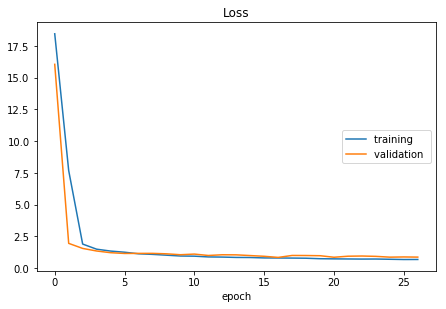

Loss
	training         	 (min:    0.501, max:   51.167, cur:    0.674)
	validation       	 (min:    0.727, max:   45.240, cur:    0.860)
1154/1154 [==============================] - 20s 17ms/step - loss: 0.6742 - val_loss: 0.8605


In [191]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=epochs,
    steps_per_epoch = len(x3train), validation_steps = len(x3test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [192]:
# save model
MODEL_FILE = "Models/ctc asl daily md.json" # save path
WEIGHT_FILE ="Models/ctc asl daily md.h5" # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [193]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
# prediction_model.summary()

In [194]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x3test))]

In [195]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'C':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

AAAAAAAAAA


In [56]:
for idx in range(len(ctc_ts3)):
    print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

1. Predicted: AAAAAAAAAAAAAAAAAAA | AAAAAAAAAAAAAAAAAAA :Original
2. Predicted: AAAAAAAAAAAA | AAAAAAAAAAAA :Original
3. Predicted: AAAAAAAAAA | AAAAAAAAAA :Original
4. Predicted: BBBBBBBBB | BBBBBBBBB :Original
5. Predicted: AAAAABBBBBBBBBBBBBA | AAAAABBBBBBBBBBBBBA :Original
6. Predicted: AABBBBBBBBBBBBB | AABBBBBBBBBBBBB :Original
7. Predicted: AAAAAAAAAAA | AAAAAAAAAAA :Original
8. Predicted: AAAAAAAAAAAAAAAAA | AAAAAAAAAAAAAAAAA :Original
9. Predicted: AAAAAAAAAAAAAA | AAAAAAAAAAAAAA :Original
10. Predicted: AAAAAAAAAA | AAAAAAAAAA :Original
11. Predicted: ABBBBBBBBBA | ABBBBBBBBBA :Original
12. Predicted: AABBBBBBBBBA | AAABBBBBBBBB :Original
13. Predicted: AABBBBBBBBBBBA | AABBBBBBBBBBBA :Original
14. Predicted: AAAAAAAAAAAA | BBBAAAAAAAAA :Original
15. Predicted: AAAAAAAAAAAAAA | AAAAAAAAAAAAAA :Original
16. Predicted: AAAAAAAAAAAAA | AAAAAAAAAAAAA :Original
17. Predicted: AAAAAAAAAAA | AAAAAAAAAAA :Original
18. Predicted: BBBBBBBBBBB | BBBBBBBBBBB :Original
19. Predicted: AABB

In [196]:
from collections import Counter
mode_orig = [max(Counter(y)) for y in ctc_ts3]
mode_pred = [max(Counter(y)) if len(y) != 0 else 'A' for y in pred_labels]

In [197]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

99.26470588235294

#### ASL model

In [85]:
# convert detected labels
ctc_tr_asl = [num_to_ch(y) for y in y3train if max(Counter(np.argmax(y,-1))) in range(4,19)]
x_train_asl = np.array([x3train[i] for i in range(len(y3train)) if max(Counter(np.argmax(y3train[i],-1))) in range(4,19)])
ctc_ts_asl = [num_to_ch(y) for y in y3test if max(Counter(np.argmax(y,-1))) in range(4,19)]
x_test_asl = np.array([x3test[i] for i in range(len(y3test)) if max(Counter(np.argmax(y3test[i],-1))) in range(4,19)])
print(x_train_asl.shape)
print(x_test_asl.shape)

(546,)
(132,)


In [86]:
characters = set(char for label in ctc_tr_asl for char in label)
print("Number of unique characters: ", len(characters))
print("Characters present: ", sorted(characters))
# print('Labels: ' + str(np.unique(ctc_tr3)))
batch_size = 1

Number of unique characters:  19
Characters present:  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S']


In [87]:
train_dataset = data_generator_ctc(x_train_asl, ctc_tr_asl)
validation_dataset = data_generator_ctc(x_test_asl, ctc_ts_asl)
predict_generator = data_generator_ctc_nolabel(x_test_asl, ctc_ts_asl)

In [105]:
model = ctc_md()
# model.summary(line_length=125)

In [106]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

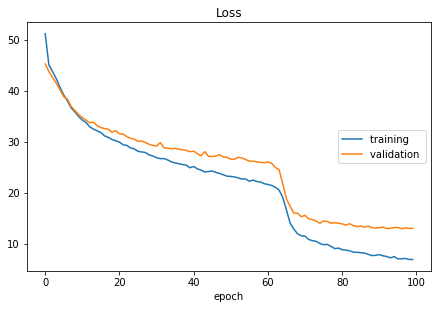

Loss
	training         	 (min:    0.501, max:   51.167, cur:    6.884)
	validation       	 (min:    0.727, max:   45.240, cur:   12.979)
546/546 [==============================] - 8s 15ms/step - loss: 6.8836 - val_loss: 12.9787


In [107]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=epochs,
    steps_per_epoch = len(x_train_asl), validation_steps = len(x_test_asl),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [108]:
# save model
MODEL_FILE = "Models/ctc asl md.json" # save path
WEIGHT_FILE ="Models/ctc asl md.h5" # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [109]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
# prediction_model.summary()

In [110]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x_test_asl))]

In [111]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

AAAPPPPPPPPPPPP


In [112]:
for idx in range(len(ctc_ts3)):
    print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

1. Predicted: ANNNNNNNN | NNNNNNNNN :Original
2. Predicted: AAAAAOOOOOOOOOOOOAA | AAAAAOOOOOOOOOOOOOA :Original
3. Predicted: AAAPPPPPPPPPPPP | AAPPPPPPPPPPPPP :Original
4. Predicted: AKKKKKKKHHH | AKKKKKKKKKA :Original
5. Predicted: AAAMMLLMMLMA | AAALLLLLLLLL :Original
6. Predicted: AAAMMMLLLLLLLA | AAMMMMMMMMMMMA :Original
7. Predicted: DDDDDDDDDPPA | PPPDDDDDDDDD :Original
8. Predicted: KKKKKKKKKKA | KKKKKKKKKKK :Original
9. Predicted: AALLLLLLLLMAA | AALLLLLLLLLLA :Original
10. Predicted: AAAMMMMMMMMMA | AAMMMMMMMMMMA :Original
11. Predicted: KKKKKA | EEEEEA :Original
12. Predicted: AFFFFFFFFFFFFFFFAAAAAGGGGGGGG | AFFFFFFFFFFFFFFFFAAAAGGGGGGGG :Original
13. Predicted: EAA | MMA :Original
14. Predicted: AAKKKKKKKKKKA | AAKKKKKKKKKKA :Original
15. Predicted: AAALLLLLLLLAA | AALLLLLLLLLLA :Original
16. Predicted: AAALLLLLLMMMMA | AAAMMMMMMMMMMA :Original
17. Predicted: AQQQQQQQQQQ | AQQQQQQQQQA :Original
18. Predicted: AAAPIRRRRRRRA | AAARRRRRRRRRA :Original
19. Predicted: AAAAASSSSS

In [113]:
from collections import Counter
mode_orig = [max(Counter(y)) for y in ctc_ts_asl]
mode_pred = [max(Counter(y)) if len(y) != 0 else 'A' for y in pred_labels]

In [115]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts_asl)) if len(mode_pred[i]) != 0]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

65.9090909090909

#### Daily model

In [122]:
# convert detected labels
ctc_tr_daily = [num_to_ch(y) for y in y3train if max(Counter(np.argmax(y,-1))) in range(0,4)]
x_train_daily = np.array([x3train[i] for i in range(len(y3train)) if max(Counter(np.argmax(y3train[i],-1))) in range(0,4)])
ctc_ts_daily = [num_to_ch(y) for y in y3test if max(Counter(np.argmax(y,-1))) in range(0,4)]
x_test_daily = np.array([x3test[i] for i in range(len(y3test)) if max(Counter(np.argmax(y3test[i],-1))) in range(0,4)])
print(x_train_daily.shape)
print(x_test_daily.shape)

(608,)
(140,)


In [123]:
characters = set(char for label in ctc_tr_daily for char in label)
print("Number of unique characters: ", len(characters))
print("Characters present: ", sorted(characters))
# print('Labels: ' + str(np.unique(ctc_tr3)))
batch_size = 1

Number of unique characters:  4
Characters present:  ['A', 'B', 'C', 'D']


In [124]:
train_dataset = data_generator_ctc(x_train_daily, ctc_tr_daily)
validation_dataset = data_generator_ctc(x_test_daily, ctc_ts_daily)
predict_generator = data_generator_ctc_nolabel(x_test_daily, ctc_ts_daily)

In [125]:
model = ctc_md()
# model.summary(line_length=125)

In [126]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

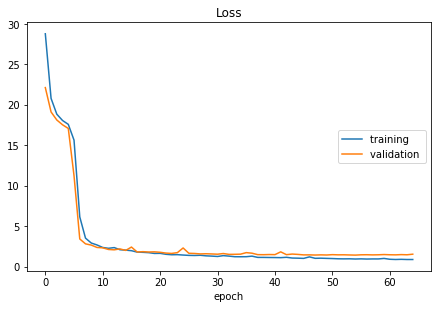

Loss
	training         	 (min:    0.501, max:   51.167, cur:    0.875)
	validation       	 (min:    0.727, max:   45.240, cur:    1.533)
608/608 [==============================] - 9s 15ms/step - loss: 0.8752 - val_loss: 1.5326


In [127]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=epochs,
    steps_per_epoch = len(x_train_daily), validation_steps = len(x_test_daily),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [128]:
# save model
MODEL_FILE = "Models/ctc daily md.json" # save path
WEIGHT_FILE ="Models/ctc daily md.h5" # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [129]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
# prediction_model.summary()

In [130]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x_test_daily))]

In [131]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'E':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

ACCCCCCCCC


In [136]:
for idx in range(len(ctc_ts_daily)):
    print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts_daily[idx] + ' :Original')

1. Predicted: AAABBBBBBBBBBBBBBBB | AAABBBBBBBBBBBBBBBB :Original
2. Predicted: BBBBBBBBBBBB | BBBBBBBBBBBB :Original
3. Predicted: ACCCCCCCCC | ACCCCCCCCA :Original
4. Predicted: AADDDDDDDDD | AADDDDDDDDA :Original
5. Predicted: AABBBBBBBBBBBBBBB | AABBBBBBBBBBBBBBB :Original
6. Predicted: BBBBBBBBBBBBBB | BBBBBBBBBBBBBB :Original
7. Predicted: ACCCCCCCCC | ACCCCCCCCA :Original
8. Predicted: AABBBBBBBBBBBB | ABBBBBBBBBBBBB :Original
9. Predicted: BBBBBBBBBBBBB | BBBBBBBBBBBBB :Original
10. Predicted: CCCCCCCCCCC | CCCCCCCCCCC :Original
11. Predicted: AADDDDDDDDDDD | AAADDDDDDDDDD :Original
12. Predicted: ABBBBBBBBB | ABBBBBBBBB :Original
13. Predicted: BBBBBBBBBBBBBCCCCCCCCCCCCCCCC | BBBBBBBBBBBBBACCCCCCCCCCCCCCC :Original
14. Predicted: AAA | AAA :Original
15. Predicted: DDDDDDD | DDDDDDA :Original
16. Predicted: AAABBBBBBBBBBBBBBB | AAABBBBBBBBBBBBBBB :Original
17. Predicted: BBBBBBBBBBBBBCCCCCCCCC | BBBBBBBBBBBBBCCCCCCCCC :Original
18. Predicted: DDDDDDDD | DDDDDDDD :Original
19. P

In [133]:
from collections import Counter
mode_orig = [max(Counter(y)) for y in ctc_ts_daily]
mode_pred = [max(Counter(y)) if len(y) != 0 else 'A' for y in pred_labels]

In [135]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts_daily)) if len(mode_pred[i]) != 0]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

100.0

### Overall testing

In [198]:
model_addr = 'Models/ctc asl daily md.json'
weight_addr = 'Models/ctc asl daily md.h5'
json_file = open(model_addr, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_asldaily = model_from_json(loaded_model_json, custom_objects={'CTCLayer': CTCLayer})
model_asldaily.load_weights(weight_addr)
model_asldaily = keras.models.Model(
    model_asldaily.get_layer(name="image").input, model_asldaily.get_layer(name="dense2").output
)

In [141]:
model_addr = 'Models/ctc daily md.json'
weight_addr = 'Models/ctc daily md.h5'
json_file = open(model_addr, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_daily = model_from_json(loaded_model_json, custom_objects={'CTCLayer': CTCLayer})
model_daily.load_weights(weight_addr)
model_daily = keras.models.Model(
    model_daily.get_layer(name="image").input, model_daily.get_layer(name="dense2").output
)

In [142]:
model_addr = 'Models/ctc asl md.json'
weight_addr = 'Models/ctc asl md.h5'
json_file = open(model_addr, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_asl = model_from_json(loaded_model_json, custom_objects={'CTCLayer': CTCLayer})
model_asl.load_weights(weight_addr)
model_asl = keras.models.Model(
    model_asl.get_layer(name="image").input, model_asl.get_layer(name="dense2").output
)

In [210]:
pred_labels = []
modes = []
cnt = 0
# predict_generator_asldaily = data_generator_ctc_nolabel(x3test, ctc_ts3)
# predict_generator_daily = data_generator_ctc_nolabel(x3test, ctc_ts_daily)
# predict_generator_asl = data_generator_ctc_nolabel(x3test, ctc_ts_asl)
for i in range(len(x3test)): # len(x3test)
#     ylabel = np.expand_dims(np.array([ord(y)%32 for y in ctc_ts3[0]]),0)
    sample = np.expand_dims(x3test[i],0)
    pred_asldaily = np.argmax(np.squeeze(model_asldaily.predict(sample)),-1)
    # remove blank
    mask = pred_asldaily == 3
    pred_noblank = pred_asldaily[~np.array(mask)]
    mode = stats.mode(pred_noblank)[0][0]
    modes.append(mode)
    label = ''
    if mode == 1: # if daily
        pred_daily = np.argmax(np.squeeze(model_daily.predict(sample)),-1)
        for num in pred_daily:
            if chr(ord('@')+num) == 'E':# or chr(ord('@')+num) == 'A':
                continue
            label = label + chr(ord('@')+num)
        pred_labels.append(label)
        cnt += 1
    else: # if asl
        pred_asl = np.argmax(np.squeeze(model_asl.predict(sample)),-1)
        for num in pred_asl:
            if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
                continue
            label = label + chr(ord('@')+num)
        pred_labels.append(label)

In [213]:
ctc_tr3 = [num_to_ch(y) for y in y3train]
ctc_ts3 = [num_to_ch(y) for y in y3test]
for idx in range(len(ctc_ts3)):
    print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

1. Predicted: AAABBBBBBBBBBBBBBBB | AAABBBBBBBBBBBBBBBB :Original
2. Predicted: BBBBBBBBBBBB | BBBBBBBBBBBB :Original
3. Predicted: ACCCCCCCCC | ACCCCCCCCA :Original
4. Predicted: ANNNNNNNN | NNNNNNNNN :Original
5. Predicted: AAAAAOOOOOOOOOOOOAA | AAAAAOOOOOOOOOOOOOA :Original
6. Predicted: AAAPPPPPPPPPPPP | AAPPPPPPPPPPPPP :Original
7. Predicted: AADDDDDDDDD | AADDDDDDDDA :Original
8. Predicted: AABBBBBBBBBBBBBBB | AABBBBBBBBBBBBBBB :Original
9. Predicted: BBBBBBBBBBBBBB | BBBBBBBBBBBBBB :Original
10. Predicted: ACCCCCCCCC | ACCCCCCCCA :Original
11. Predicted: AKKKKKKKHHH | AKKKKKKKKKA :Original
12. Predicted: AAAMMLLMMLMA | AAALLLLLLLLL :Original
13. Predicted: AAAMMMLLLLLLLA | AAMMMMMMMMMMMA :Original
14. Predicted: DDDDDDDDDDDD | PPPDDDDDDDDD :Original
15. Predicted: AABBBBBBBBBBBB | ABBBBBBBBBBBBB :Original
16. Predicted: BBBBBBBBBBBBB | BBBBBBBBBBBBB :Original
17. Predicted: CCCCCCCCCCC | CCCCCCCCCCC :Original
18. Predicted: KKKKKKKKKKA | KKKKKKKKKKK :Original
19. Predicted: AALL

In [214]:
from collections import Counter
mode_orig = [max(Counter(y)) for y in ctc_ts3]
mode_pred = [max(Counter(y)) if len(y) != 0 else 'A' for y in pred_labels]

In [215]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

83.08823529411765